Project Phase 2:
- Implement Transfer learning using all the pretrained models (vgg16, resnet-50, densenet121, mobilenet, inception, …) - we will take them
- ⁠record the performance measures
- ⁠Fine tune each of the previous model by fine tuning the final 2 or more convolutional layers
- ⁠record the performance measures and choose the best.
- ⁠add one more convolutional layer to the model and fine tune it.
- ⁠record the results performance should be getting better
- ⁠apply pretrained vision transformer on your dataset
- ⁠record the performance
- outputs to be delivered: 

1- the code of all implementations

2- report explaining the problem, dataset description, how cross validation is done, any preprocessing done +
explaining what is done in each step and all the recorded performance measures

3- conclusion of which architecture and learning resulted in the best performance

# importing libraries needed

In [1]:
import os
import torch
import numpy as np
import optuna
from torchvision import datasets, transforms, models
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, Subset, random_split
from torch.optim import Adam
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm
from sklearn.decomposition import PCA

In [2]:
# to get the same results every time we run
torch.manual_seed(42) # Setting the seed

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)

Device cuda


# load the data

In [4]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder(root='dataset', transform=transform)
print(f"dataset len: {len(dataset)}")
print(f"Number of classes: {len(dataset.classes)}")

dataset len: 10000
Number of classes: 2


In [5]:
# Extract image data
# #image_data = []
# for image, _ in dataset:
#    image_data.append(image.numpy().flatten()) 
# # Apply PCA
# pca = PCA(n_components=0.95)  # Keep 95% of the variance
# pca.fit(image_data)
# reduced_data = pca.transform(image_data) # memory error 
# print("Number of principal components:", pca.n_components_) 

# Split the dataset in half to have faster results
half_dataset_size = len(dataset) // 2
first_half_dataset, _ = torch.utils.data.random_split(dataset, [half_dataset_size, half_dataset_size])
print(f"dataset len: {len(first_half_dataset)}")
## Extract image data from the half
#image_data = []
#for image, _ in first_half_dataset:
#    image_data.append(image.numpy().flatten()) 

## Apply PCA
# pca = PCA(n_components=0.95)  # Keep 95% of the variance
# pca.fit(image_data)
# reduced_data = pca.transform(image_data) # memory error
# print("Number of principal components:", pca.n_components_) 

dataset len: 5000


In [6]:
# Split the dataset into training and validation sets
train_size_reduced = int(0.8 * len(first_half_dataset))  # 80% training
val_size_reduced = len(first_half_dataset) - train_size_reduced  # 20% validation
train_dataset_reduced, val_dataset_reduced = random_split(first_half_dataset, [train_size_reduced, val_size_reduced])

train_loader_reduced = DataLoader(train_dataset_reduced, batch_size=32, shuffle=True)
val_loader_reduced = DataLoader(val_dataset_reduced, batch_size=32, shuffle=False)

print(f"Train len: {len(train_loader_reduced) * 32}")
print(f"Validation len: {len(val_loader_reduced) * 32}")

Train len: 4000
Validation len: 1024


# TPE (Tree-structured Parzen Estimator) search to choose best lr for our models

## helper function to evaluate the model

In [7]:
import torch
import torch.nn as nn
from torchvision.models import vgg16, resnet50, densenet121, mobilenet_v2
from torchvision.models import VGG16_Weights, ResNet50_Weights, DenseNet121_Weights, MobileNet_V2_Weights

In [8]:
our_models = ["VGG16", "ResNet-50", "DenseNet121", "MobileNet"]

def initialize_model(model_name, num_classes):
    if model_name == "VGG16":
        model = vgg16(weights=VGG16_Weights.DEFAULT)  # Load the most up-to-date weights for VGG16
        for param in model.parameters():
            param.requires_grad = False
        num_ftrs = model.classifier[6].in_features
        model.classifier[6] = nn.Linear(num_ftrs, num_classes)
    elif model_name == "ResNet-50":
        model = resnet50(weights=ResNet50_Weights.DEFAULT)  # Load the most up-to-date weights for ResNet-50
        for param in model.parameters():
            param.requires_grad = False
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)
    elif model_name == "DenseNet121":
        model = densenet121(weights=DenseNet121_Weights.DEFAULT)  # Load the most up-to-date weights for DenseNet121
        for param in model.parameters():
            param.requires_grad = False
        num_ftrs = model.classifier.in_features
        model.classifier = nn.Linear(num_ftrs, num_classes)
    elif model_name == "MobileNet":
        model = mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)  # Load the most up-to-date weights for MobileNet
        for param in model.parameters():
            param.requires_grad = False
        num_ftrs = model.last_channel
        model.classifier[1] = nn.Linear(num_ftrs, num_classes)
    else:
        print(f"Error: Model '{model_name}' not supported.")
        return None

    return model

In [14]:
def train_model(model, train_loader, val_loader, lr, num_epoch=2):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=lr)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    model.train()
    for epoch in range(num_epoch):  
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        total_loss = 0.0 
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
        val_loss = total_loss / len(val_loader_reduced)

    return val_loss

In [10]:
from hyperopt import fmin, tpe, hp

In [15]:
def objective(params):
    lr = params['lr']

    # Create the model
    model = resnet50(weights=ResNet50_Weights.DEFAULT)
    for param in model.parameters():
        param.requires_grad = False
    num_ftrs = model.fc.in_features
    num_classes = len(dataset.classes)
    model.fc = nn.Linear(num_ftrs, num_classes)

    val_loss = train_model(model, train_loader_reduced, val_loader_reduced, lr, num_epoch=2)
    
    return val_loss # Returns:Loss value on the validation set.


# Define the search space for hyperopt
space = {
    'lr': hp.loguniform('lr', np.log(1e-5), np.log(1e-2))  # Search learning rate logarithmically
}

# Run hyperopt optimization
best = fmin(fn=objective,
           space=space,
           algo=tpe.suggest,
           max_evals=5)  

# Print the best hyperparameters
print("Best hyperparameters:", best)

100%|██████████████████████████████████████████████████| 5/5 [04:02<00:00, 48.46s/trial, best loss: 0.3749630614183843]
Best hyperparameters: {'lr': 0.003001253154810488}


In [15]:
def objective(params, _model):
    lr = params['lr']

    # Create the model
    num_classes = len(dataset.classes)
    model = initialize_model(_model, num_classes)
    val_loss = train_model(model, train_loader_reduced, val_loader_reduced, lr, num_epoch=2)
    
    return val_loss  # Returns: Loss value on the validation set.

models_best_params = {}
for model in our_models:
    # Define the search space for hyperopt
    space = {
        'lr': hp.loguniform('lr', np.log(1e-5), np.log(1e-2))  # Search learning rate logarithmically
    }
    
    # Use a lambda function to pass `_model` to the objective function
    best = fmin(
        fn=lambda params: objective(params, _model=model),  # Takes params as its input (a dictionary with hyperparameters like lr).
        space=space,
        algo=tpe.suggest,
        max_evals=5
    )
    
    models_best_params[f'{model}'] = best
    print(f"Best hyperparameters for {model}:", best)

100%|█████████████████████████████████████████████████| 5/5 [17:06<00:00, 205.35s/trial, best loss: 0.6023138957098126]
Best hyperparameters for VGG16: {'lr': 8.440453952880984e-05}
100%|██████████████████████████████████████████████████| 5/5 [04:09<00:00, 49.97s/trial, best loss: 0.4203595481812954]
Best hyperparameters for ResNet-50: {'lr': 0.0012807139284544634}
100%|██████████████████████████████████████████████████| 5/5 [04:18<00:00, 51.68s/trial, best loss: 0.5145052392035723]
Best hyperparameters for DenseNet121: {'lr': 0.0004112928002730808}
  0%|                                                                            | 0/5 [00:00<?, ?trial/s, best loss=?]

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to C:\Users\menam/.cache\torch\hub\checkpoints\mobilenet_v2-7ebf99e0.pth

  0%|                                                                                      | 0.00/13.6M [00:00<?, ?B/s]

  3%|##1                                                                           | 384k/13.6M [00:00<00:03, 3.49MB/s]

  6%|####3                                                                         | 768k/13.6M [00:00<00:03, 3.68MB/s]

  8%|######3                                                                      | 1.12M/13.6M [00:00<00:03, 3.77MB/s]

 12%|#########2                                                                   | 1.62M/13.6M [00:00<00:03, 3.84MB/s]

 15%|###########3                                                                 | 2.00M/13.6M [00:00<00:03, 3.30MB/s]

 17%|#############4                                                               | 2.38M/13.6M [00:00<00:03, 3.25MB/s]

 2

100%|█████████████████████████████████████████████████| 5/5 [02:27<00:00, 29.55s/trial, best loss: 0.45707301516085863]
Best hyperparameters for MobileNet: {'lr': 0.0017952256762670846}


In [17]:
for model, best_params in models_best_params.items():
    print(f"Model: {model}")
    print(f"Best Hyperparameters: {best_params}")
    print("-" * 30)  

Model: VGG16
Best Hyperparameters: {'lr': 8.440453952880984e-05}
------------------------------
Model: ResNet-50
Best Hyperparameters: {'lr': 0.0012807139284544634}
------------------------------
Model: DenseNet121
Best Hyperparameters: {'lr': 0.0004112928002730808}
------------------------------
Model: MobileNet
Best Hyperparameters: {'lr': 0.0017952256762670846}
------------------------------


In [22]:
def get_learning_rate(model_name):
    return models_best_params.get(model_name, {}).get("lr", "Model not found")

model_name = "ResNet-50"
learning_rate = get_learning_rate(model_name)
print(f"The learning rate for {model_name} is {learning_rate}")

The learning rate for ResNet-50 is 0.0012807139284544634


# Split the data into k folds

In [18]:
n_splits = 3

# Initialize KFold
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# function to measure performance 

In [19]:
def performance_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='weighted')
    rec = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    return cm, acc, prec, rec, f1

# train and validate function

In [20]:
from datetime import datetime

In [21]:
def train_validate_model(model, criterion, optimizer, train_loader, val_loader, fold, model_name, num_epochs=3):
    train_validate_history = {}
    best_model_wts = None
    best_val_acc = 0.0
    
    # Create folder structure for saving best models
    save_dir = os.path.join("bestmodelsV4", f"fold{fold+1}")
    os.makedirs(save_dir, exist_ok=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    model.train()  

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        
        # Training
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in tqdm(train_loader, desc="Training"):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        train_loss = running_loss / len(train_loader.dataset)
        train_acc = running_corrects.double() / len(train_loader.dataset)
        print(f"[{model_name}] Fold {fold+1}, Epoch {epoch+1}: Train Loss: {train_loss:.2f} Acc: {train_acc:.2f}")

        # Validation
        model.eval()
        val_loss = 0.0
        val_corrects = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)
                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)

        val_loss = val_loss / len(val_loader.dataset)
        val_acc = val_corrects.double() / len(val_loader.dataset)
        print(f"[{model_name}] Fold {fold+1}, Epoch {epoch+1}: Validation Loss: {val_loss:.2f} Acc: {val_acc:.2f}\n")

        # Store the results in the history dictionary
        train_validate_history[f"{model_name}_fold{fold+1}_epoch{epoch+1}"] = {
            "train_loss": train_loss,
            "train_acc": train_acc.item(),
            "val_loss": val_loss,
            "val_acc": val_acc.item(),
        }

        # Save best model based on validation accuracy
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_wts = model.state_dict().copy()  

        model.train()

    # Save the best model weights to the specified directory
    best_model_path = os.path.join(save_dir, f"{model_name}_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.pth")
    if best_model_wts:
        torch.save(best_model_wts, best_model_path)
        print(f"Best model for {model_name} (Fold {fold+1}) saved at: {best_model_path}")

    return model, train_validate_history

In [23]:
results = {model_name: [] for model_name in our_models}
train_val_hist = []

for fold, (train_idx, test_idx) in enumerate(kf.split(dataset)):
    print(f"Fold {fold+1}/{n_splits}")

    train_set = Subset(dataset, train_idx)
    test_set = Subset(dataset, test_idx)
    val_split = int(len(train_set) * 0.8)
    val_set = Subset(train_set, range(val_split, len(train_set)))
    train_set = Subset(train_set, range(0, val_split))

    train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_set, batch_size=32, shuffle=False)
    
    for model_name in our_models:
        num_classes = len(dataset.classes)
        
        # Initializing the model every time ensures that no previous model parameters are retained
        model = initialize_model(model_name, num_classes)

        # getting best lr for each model
        l_r = get_learning_rate(model_name)

        criterion = torch.nn.CrossEntropyLoss()
        optimizer = Adam(model.parameters(), lr=l_r) 

        model , train_val_history = train_validate_model(model, criterion, optimizer, train_loader, val_loader, fold, model_name, num_epochs=3)
        train_val_hist.append(train_val_history)
        
        # Test the model
        model.eval()
        y_true, y_pred = [], []
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.cuda(), labels.cuda() if torch.cuda.is_available() else (images, labels)
                outputs = model(images)
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(outputs.argmax(1).cpu().numpy())

        cm, acc, prec, rec, f1 = performance_matrix(y_true, y_pred)

        results[model_name].append({
            "confusion_matrix": cm,
            "accuracy": acc,
            "precision": prec,
            "recall": rec,
            "f1_score": f1
        })

Fold 1/3
Epoch 1/3


Training: 100%|██████████████████████████████████████████████████████████████████████| 167/167 [02:00<00:00,  1.39it/s]


[VGG16] Fold 1, Epoch 1: Train Loss: 0.65 Acc: 0.63
[VGG16] Fold 1, Epoch 1: Validation Loss: 0.93 Acc: 0.26

Epoch 2/3


Training: 100%|██████████████████████████████████████████████████████████████████████| 167/167 [01:59<00:00,  1.40it/s]


[VGG16] Fold 1, Epoch 2: Train Loss: 0.59 Acc: 0.69
[VGG16] Fold 1, Epoch 2: Validation Loss: 0.87 Acc: 0.35

Epoch 3/3


Training: 100%|██████████████████████████████████████████████████████████████████████| 167/167 [01:58<00:00,  1.41it/s]


[VGG16] Fold 1, Epoch 3: Train Loss: 0.56 Acc: 0.72
[VGG16] Fold 1, Epoch 3: Validation Loss: 0.90 Acc: 0.36

Best model for VGG16 (Fold 1) saved at: bestmodelsV4\fold1\VGG16_2024-12-26_17-08-19.pth
Epoch 1/3


Training: 100%|██████████████████████████████████████████████████████████████████████| 167/167 [00:40<00:00,  4.17it/s]


[ResNet-50] Fold 1, Epoch 1: Train Loss: 0.50 Acc: 0.76
[ResNet-50] Fold 1, Epoch 1: Validation Loss: 0.45 Acc: 0.81

Epoch 2/3


Training: 100%|██████████████████████████████████████████████████████████████████████| 167/167 [00:40<00:00,  4.15it/s]


[ResNet-50] Fold 1, Epoch 2: Train Loss: 0.38 Acc: 0.84
[ResNet-50] Fold 1, Epoch 2: Validation Loss: 0.53 Acc: 0.72

Epoch 3/3


Training: 100%|██████████████████████████████████████████████████████████████████████| 167/167 [00:40<00:00,  4.12it/s]


[ResNet-50] Fold 1, Epoch 3: Train Loss: 0.34 Acc: 0.86
[ResNet-50] Fold 1, Epoch 3: Validation Loss: 0.51 Acc: 0.74

Best model for ResNet-50 (Fold 1) saved at: bestmodelsV4\fold1\ResNet-50_2024-12-26_17-12-05.pth
Epoch 1/3


Training: 100%|██████████████████████████████████████████████████████████████████████| 167/167 [00:41<00:00,  3.99it/s]


[DenseNet121] Fold 1, Epoch 1: Train Loss: 0.59 Acc: 0.69
[DenseNet121] Fold 1, Epoch 1: Validation Loss: 0.73 Acc: 0.54

Epoch 2/3


Training: 100%|██████████████████████████████████████████████████████████████████████| 167/167 [00:41<00:00,  3.99it/s]


[DenseNet121] Fold 1, Epoch 2: Train Loss: 0.49 Acc: 0.78
[DenseNet121] Fold 1, Epoch 2: Validation Loss: 0.61 Acc: 0.66

Epoch 3/3


Training: 100%|██████████████████████████████████████████████████████████████████████| 167/167 [00:42<00:00,  3.95it/s]


[DenseNet121] Fold 1, Epoch 3: Train Loss: 0.45 Acc: 0.80
[DenseNet121] Fold 1, Epoch 3: Validation Loss: 0.65 Acc: 0.64

Best model for DenseNet121 (Fold 1) saved at: bestmodelsV4\fold1\DenseNet121_2024-12-26_17-15-06.pth
Epoch 1/3


Training: 100%|██████████████████████████████████████████████████████████████████████| 167/167 [00:22<00:00,  7.32it/s]


[MobileNet] Fold 1, Epoch 1: Train Loss: 0.53 Acc: 0.75
[MobileNet] Fold 1, Epoch 1: Validation Loss: 0.46 Acc: 0.81

Epoch 2/3


Training: 100%|██████████████████████████████████████████████████████████████████████| 167/167 [00:22<00:00,  7.37it/s]


[MobileNet] Fold 1, Epoch 2: Train Loss: 0.45 Acc: 0.79
[MobileNet] Fold 1, Epoch 2: Validation Loss: 0.47 Acc: 0.78

Epoch 3/3


Training: 100%|██████████████████████████████████████████████████████████████████████| 167/167 [00:22<00:00,  7.35it/s]


[MobileNet] Fold 1, Epoch 3: Train Loss: 0.42 Acc: 0.80
[MobileNet] Fold 1, Epoch 3: Validation Loss: 0.71 Acc: 0.61

Best model for MobileNet (Fold 1) saved at: bestmodelsV4\fold1\MobileNet_2024-12-26_17-16-56.pth
Fold 2/3
Epoch 1/3


Training: 100%|██████████████████████████████████████████████████████████████████████| 167/167 [01:59<00:00,  1.40it/s]


[VGG16] Fold 2, Epoch 1: Train Loss: 0.65 Acc: 0.63
[VGG16] Fold 2, Epoch 1: Validation Loss: 0.90 Acc: 0.27

Epoch 2/3


Training: 100%|██████████████████████████████████████████████████████████████████████| 167/167 [01:58<00:00,  1.41it/s]


[VGG16] Fold 2, Epoch 2: Train Loss: 0.60 Acc: 0.68
[VGG16] Fold 2, Epoch 2: Validation Loss: 0.95 Acc: 0.29

Epoch 3/3


Training: 100%|██████████████████████████████████████████████████████████████████████| 167/167 [01:58<00:00,  1.41it/s]


[VGG16] Fold 2, Epoch 3: Train Loss: 0.58 Acc: 0.70
[VGG16] Fold 2, Epoch 3: Validation Loss: 0.88 Acc: 0.37

Best model for VGG16 (Fold 2) saved at: bestmodelsV4\fold2\VGG16_2024-12-26_17-24-35.pth
Epoch 1/3


Training: 100%|██████████████████████████████████████████████████████████████████████| 167/167 [00:40<00:00,  4.12it/s]


[ResNet-50] Fold 2, Epoch 1: Train Loss: 0.50 Acc: 0.76
[ResNet-50] Fold 2, Epoch 1: Validation Loss: 0.69 Acc: 0.59

Epoch 2/3


Training: 100%|██████████████████████████████████████████████████████████████████████| 167/167 [00:40<00:00,  4.09it/s]


[ResNet-50] Fold 2, Epoch 2: Train Loss: 0.39 Acc: 0.84
[ResNet-50] Fold 2, Epoch 2: Validation Loss: 0.50 Acc: 0.76

Epoch 3/3


Training: 100%|██████████████████████████████████████████████████████████████████████| 167/167 [00:41<00:00,  4.07it/s]


[ResNet-50] Fold 2, Epoch 3: Train Loss: 0.35 Acc: 0.86
[ResNet-50] Fold 2, Epoch 3: Validation Loss: 0.65 Acc: 0.65

Best model for ResNet-50 (Fold 2) saved at: bestmodelsV4\fold2\ResNet-50_2024-12-26_17-28-22.pth
Epoch 1/3


Training: 100%|██████████████████████████████████████████████████████████████████████| 167/167 [00:42<00:00,  3.95it/s]


[DenseNet121] Fold 2, Epoch 1: Train Loss: 0.59 Acc: 0.69
[DenseNet121] Fold 2, Epoch 1: Validation Loss: 0.67 Acc: 0.60

Epoch 2/3


Training: 100%|██████████████████████████████████████████████████████████████████████| 167/167 [00:42<00:00,  3.96it/s]


[DenseNet121] Fold 2, Epoch 2: Train Loss: 0.50 Acc: 0.76
[DenseNet121] Fold 2, Epoch 2: Validation Loss: 0.54 Acc: 0.74

Epoch 3/3


Training: 100%|██████████████████████████████████████████████████████████████████████| 167/167 [00:42<00:00,  3.95it/s]


[DenseNet121] Fold 2, Epoch 3: Train Loss: 0.46 Acc: 0.80
[DenseNet121] Fold 2, Epoch 3: Validation Loss: 0.59 Acc: 0.70

Best model for DenseNet121 (Fold 2) saved at: bestmodelsV4\fold2\DenseNet121_2024-12-26_17-31-24.pth
Epoch 1/3


Training: 100%|██████████████████████████████████████████████████████████████████████| 167/167 [00:22<00:00,  7.39it/s]


[MobileNet] Fold 2, Epoch 1: Train Loss: 0.52 Acc: 0.75
[MobileNet] Fold 2, Epoch 1: Validation Loss: 0.52 Acc: 0.73

Epoch 2/3


Training: 100%|██████████████████████████████████████████████████████████████████████| 167/167 [00:22<00:00,  7.39it/s]


[MobileNet] Fold 2, Epoch 2: Train Loss: 0.45 Acc: 0.79
[MobileNet] Fold 2, Epoch 2: Validation Loss: 0.57 Acc: 0.70

Epoch 3/3


Training: 100%|██████████████████████████████████████████████████████████████████████| 167/167 [00:22<00:00,  7.38it/s]


[MobileNet] Fold 2, Epoch 3: Train Loss: 0.43 Acc: 0.80
[MobileNet] Fold 2, Epoch 3: Validation Loss: 0.75 Acc: 0.58

Best model for MobileNet (Fold 2) saved at: bestmodelsV4\fold2\MobileNet_2024-12-26_17-33-14.pth
Fold 3/3
Epoch 1/3


Training: 100%|██████████████████████████████████████████████████████████████████████| 167/167 [01:58<00:00,  1.41it/s]


[VGG16] Fold 3, Epoch 1: Train Loss: 0.65 Acc: 0.64
[VGG16] Fold 3, Epoch 1: Validation Loss: 0.85 Acc: 0.32

Epoch 2/3


Training: 100%|██████████████████████████████████████████████████████████████████████| 167/167 [01:58<00:00,  1.41it/s]


[VGG16] Fold 3, Epoch 2: Train Loss: 0.59 Acc: 0.69
[VGG16] Fold 3, Epoch 2: Validation Loss: 0.85 Acc: 0.38

Epoch 3/3


Training: 100%|██████████████████████████████████████████████████████████████████████| 167/167 [01:58<00:00,  1.41it/s]


[VGG16] Fold 3, Epoch 3: Train Loss: 0.56 Acc: 0.71
[VGG16] Fold 3, Epoch 3: Validation Loss: 0.87 Acc: 0.39

Best model for VGG16 (Fold 3) saved at: bestmodelsV4\fold3\VGG16_2024-12-26_17-40-52.pth
Epoch 1/3


Training: 100%|██████████████████████████████████████████████████████████████████████| 167/167 [00:40<00:00,  4.15it/s]


[ResNet-50] Fold 3, Epoch 1: Train Loss: 0.49 Acc: 0.77
[ResNet-50] Fold 3, Epoch 1: Validation Loss: 0.59 Acc: 0.69

Epoch 2/3


Training: 100%|██████████████████████████████████████████████████████████████████████| 167/167 [00:41<00:00,  4.07it/s]


[ResNet-50] Fold 3, Epoch 2: Train Loss: 0.37 Acc: 0.84
[ResNet-50] Fold 3, Epoch 2: Validation Loss: 0.46 Acc: 0.78

Epoch 3/3


Training: 100%|██████████████████████████████████████████████████████████████████████| 167/167 [00:41<00:00,  4.07it/s]


[ResNet-50] Fold 3, Epoch 3: Train Loss: 0.33 Acc: 0.87
[ResNet-50] Fold 3, Epoch 3: Validation Loss: 0.44 Acc: 0.79

Best model for ResNet-50 (Fold 3) saved at: bestmodelsV4\fold3\ResNet-50_2024-12-26_17-44-39.pth
Epoch 1/3


Training: 100%|██████████████████████████████████████████████████████████████████████| 167/167 [00:41<00:00,  3.98it/s]


[DenseNet121] Fold 3, Epoch 1: Train Loss: 0.58 Acc: 0.70
[DenseNet121] Fold 3, Epoch 1: Validation Loss: 0.72 Acc: 0.54

Epoch 2/3


Training: 100%|██████████████████████████████████████████████████████████████████████| 167/167 [00:42<00:00,  3.96it/s]


[DenseNet121] Fold 3, Epoch 2: Train Loss: 0.49 Acc: 0.77
[DenseNet121] Fold 3, Epoch 2: Validation Loss: 0.70 Acc: 0.59

Epoch 3/3


Training: 100%|██████████████████████████████████████████████████████████████████████| 167/167 [00:42<00:00,  3.97it/s]


[DenseNet121] Fold 3, Epoch 3: Train Loss: 0.45 Acc: 0.80
[DenseNet121] Fold 3, Epoch 3: Validation Loss: 0.59 Acc: 0.68

Best model for DenseNet121 (Fold 3) saved at: bestmodelsV4\fold3\DenseNet121_2024-12-26_17-47-41.pth
Epoch 1/3


Training: 100%|██████████████████████████████████████████████████████████████████████| 167/167 [00:22<00:00,  7.29it/s]


[MobileNet] Fold 3, Epoch 1: Train Loss: 0.51 Acc: 0.75
[MobileNet] Fold 3, Epoch 1: Validation Loss: 0.64 Acc: 0.64

Epoch 2/3


Training: 100%|██████████████████████████████████████████████████████████████████████| 167/167 [00:22<00:00,  7.45it/s]


[MobileNet] Fold 3, Epoch 2: Train Loss: 0.43 Acc: 0.81
[MobileNet] Fold 3, Epoch 2: Validation Loss: 0.64 Acc: 0.64

Epoch 3/3


Training: 100%|██████████████████████████████████████████████████████████████████████| 167/167 [00:22<00:00,  7.41it/s]


[MobileNet] Fold 3, Epoch 3: Train Loss: 0.42 Acc: 0.81
[MobileNet] Fold 3, Epoch 3: Validation Loss: 0.62 Acc: 0.67

Best model for MobileNet (Fold 3) saved at: bestmodelsV4\fold3\MobileNet_2024-12-26_17-49-31.pth


In [24]:
for model_name, metrics in results.items():
    print(f"Results for {model_name}:")
    for fold_idx, fold_metrics in enumerate(metrics):
        print(f"  Fold {fold_idx+1}:")
        print(f"    Confusion Matrix:\n{fold_metrics['confusion_matrix']}")
        print(f"    Accuracy: {fold_metrics['accuracy']:.4f}")
        print(f"    Precision: {fold_metrics['precision']:.4f}")
        print(f"    Recall: {fold_metrics['recall']:.4f}")
        print(f"    F1 Score: {fold_metrics['f1_score']:.4f}")

    # Calculate averages
    avg_acc = np.mean([m["accuracy"] for m in metrics])
    avg_prec = np.mean([m["precision"] for m in metrics])
    avg_rec = np.mean([m["recall"] for m in metrics])
    avg_f1 = np.mean([m["f1_score"] for m in metrics])

    print(f"  Averages:")
    print(f"    Accuracy: {avg_acc:.4f}")
    print(f"    Precision: {avg_prec:.4f}")
    print(f"    Recall: {avg_rec:.4f}")
    print(f"    F1 Score: {avg_f1:.4f}")

Results for VGG16:
  Fold 1:
    Confusion Matrix:
[[1562  130]
 [1013  629]]
    Accuracy: 0.6572
    Precision: 0.7160
    Recall: 0.6572
    F1 Score: 0.6296
  Fold 2:
    Confusion Matrix:
[[1601   97]
 [1075  560]]
    Accuracy: 0.6484
    Precision: 0.7229
    Recall: 0.6484
    F1 Score: 0.6127
  Fold 3:
    Confusion Matrix:
[[1495  115]
 [1068  655]]
    Accuracy: 0.6451
    Precision: 0.7215
    Recall: 0.6451
    F1 Score: 0.6178
  Averages:
    Accuracy: 0.6502
    Precision: 0.7201
    Recall: 0.6502
    F1 Score: 0.6200
Results for ResNet-50:
  Fold 1:
    Confusion Matrix:
[[1552  140]
 [ 360 1282]]
    Accuracy: 0.8500
    Precision: 0.8560
    Recall: 0.8500
    F1 Score: 0.8492
  Fold 2:
    Confusion Matrix:
[[1637   61]
 [ 621 1014]]
    Accuracy: 0.7954
    Precision: 0.8321
    Recall: 0.7954
    F1 Score: 0.7887
  Fold 3:
    Confusion Matrix:
[[1427  183]
 [ 363 1360]]
    Accuracy: 0.8362
    Precision: 0.8407
    Recall: 0.8362
    F1 Score: 0.8360
  Averages:

# plotting the results

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

## Confusion Matrix

In [25]:
def plot_heatmap(confusion_matrix, class_names, model_name):
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

Results for VGG16:


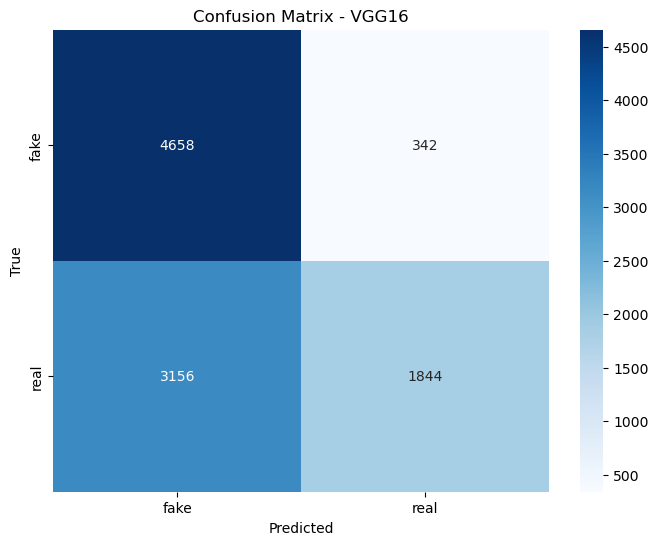

Results for ResNet-50:


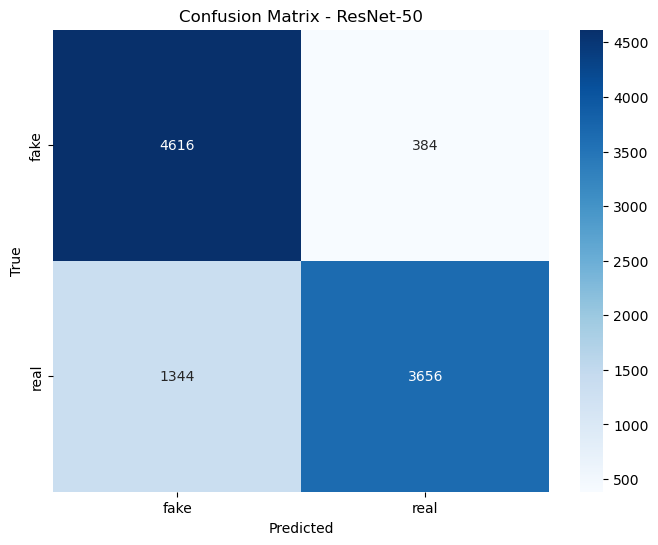

Results for DenseNet121:


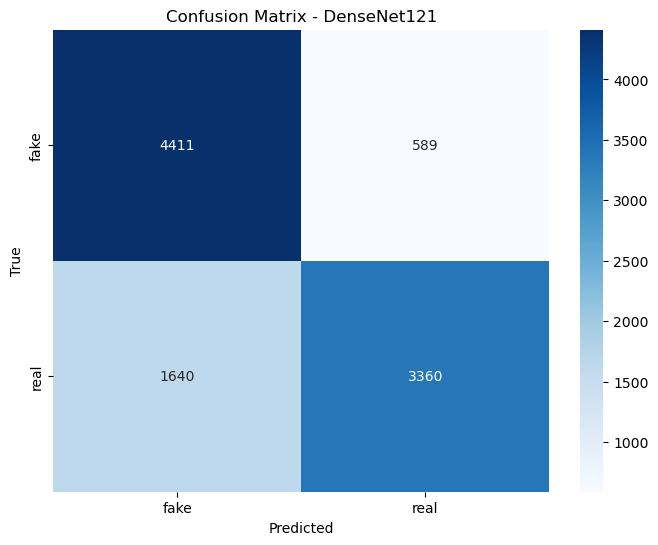

Results for MobileNet:


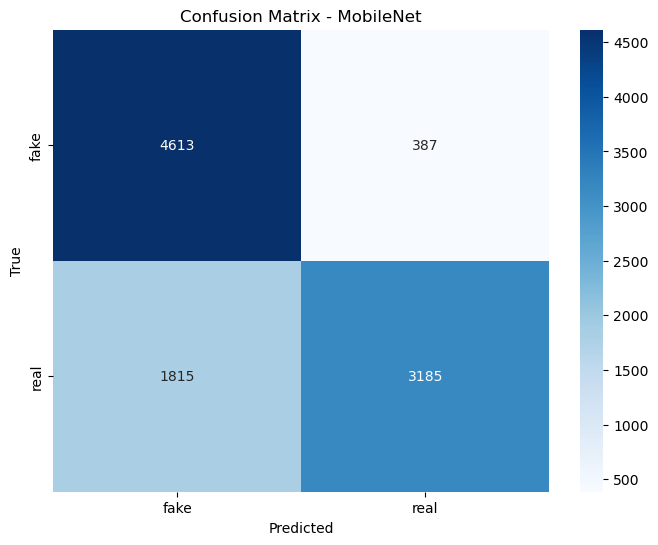

In [28]:
class_names = dataset.classes  

for model_name, metrics in results.items():
    print(f"Results for {model_name}:")
    sum_of_cms = 0
    for fold_idx, fold_metrics in enumerate(metrics):
        sum_of_cms+= fold_metrics['confusion_matrix']
        
    plot_heatmap(sum_of_cms, class_names, model_name)

## Bar Chart for Average Metrics

In [29]:
models = list(results.keys())
metrics = ["accuracy", "precision", "recall", "f1_score"]
avg_metrics = {model: [
    np.mean([fold[metric] for fold in results[model]]) for metric in metrics
] for model in models}
fold_metrics = {model: [
    [fold[metric] for metric in metrics] for fold in results[model]
] for model in models}
conf_matrices = {model: [
    np.array(fold["confusion_matrix"]) for fold in results[model]
] for model in models}

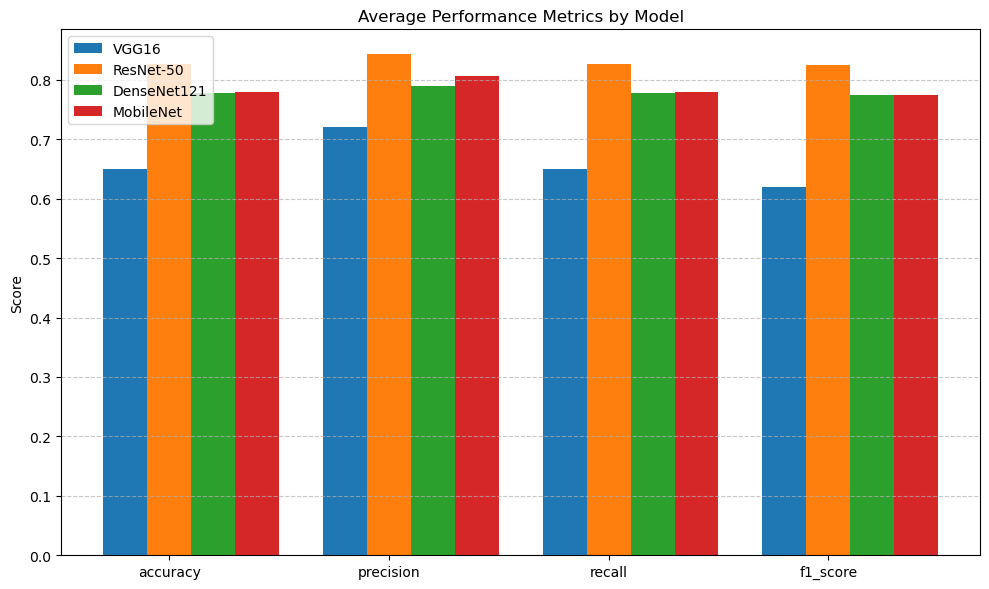

In [30]:
plt.figure(figsize=(10, 6))
x = np.arange(len(metrics))
width = 0.2

for i, model in enumerate(models):
    plt.bar(x + i * width, avg_metrics[model], width, label=model)

plt.xticks(x + width, metrics)
plt.ylabel('Score')
plt.title('Average Performance Metrics by Model')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# ⁠Fine tune each of the previous model by fine tuning the final 2 layers

In [31]:
def freeze_all_except_last_two_layers(model):
    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze the last two layers
    for child in list(model.children())[-2:]:
        for param in child.parameters():
            param.requires_grad = True

def initialize_model(model_name, num_classes):
    if model_name == "VGG16":
        model = vgg16(weights=VGG16_Weights.DEFAULT)
        freeze_all_except_last_two_layers(model)
        num_ftrs = model.classifier[6].in_features
        model.classifier[6] = nn.Linear(num_ftrs, num_classes)
    elif model_name == "ResNet-50":
        model = resnet50(weights=ResNet50_Weights.DEFAULT)
        freeze_all_except_last_two_layers(model)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)
    elif model_name == "DenseNet121":
        model = densenet121(weights=DenseNet121_Weights.DEFAULT)
        freeze_all_except_last_two_layers(model)
        num_ftrs = model.classifier.in_features
        model.classifier = nn.Linear(num_ftrs, num_classes)
    elif model_name == "MobileNet":
        model = mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)
        freeze_all_except_last_two_layers(model)
        num_ftrs = model.last_channel
        model.classifier[1] = nn.Linear(num_ftrs, num_classes)
    else:
        print(f"Error: Model '{model_name}' not supported.")
        return None

    return model

In [32]:
results = {model_name: [] for model_name in our_models}
train_val_hist = []

for fold, (train_idx, test_idx) in enumerate(kf.split(dataset)):
    print(f"Fold {fold+1}/{n_splits}")

    train_set = Subset(dataset, train_idx)
    test_set = Subset(dataset, test_idx)
    val_split = int(len(train_set) * 0.8)
    val_set = Subset(train_set, range(val_split, len(train_set)))
    train_set = Subset(train_set, range(0, val_split))

    train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_set, batch_size=32, shuffle=False)
    
    for model_name in our_models:
        num_classes = len(dataset.classes)
        
        # Initializing the model every time ensures that no previous model parameters are retained
        model = initialize_model(model_name, num_classes)

        # getting best lr for each model
        l_r = get_learning_rate(model_name)

        criterion = torch.nn.CrossEntropyLoss()
        optimizer = Adam(model.parameters(), lr=l_r) 

        model , train_val_history = train_validate_model(model, criterion, optimizer, train_loader, val_loader, fold, model_name, num_epochs=2)
        train_val_hist.append(train_val_history)
        
        # Test the model
        model.eval()
        y_true, y_pred = [], []
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.cuda(), labels.cuda() if torch.cuda.is_available() else (images, labels)
                outputs = model(images)
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(outputs.argmax(1).cpu().numpy())

        cm, acc, prec, rec, f1 = performance_matrix(y_true, y_pred)

        results[model_name].append({
            "confusion_matrix": cm,
            "accuracy": acc,
            "precision": prec,
            "recall": rec,
            "f1_score": f1
        })

Fold 1/3
Epoch 1/2


Training: 100%|██████████████████████████████████████████████████████████████████████| 167/167 [02:31<00:00,  1.10it/s]


[VGG16] Fold 1, Epoch 1: Train Loss: 0.49 Acc: 0.77
[VGG16] Fold 1, Epoch 1: Validation Loss: 0.66 Acc: 0.65

Epoch 2/2


Training: 100%|██████████████████████████████████████████████████████████████████████| 167/167 [03:14<00:00,  1.17s/it]


[VGG16] Fold 1, Epoch 2: Train Loss: 0.26 Acc: 0.90
[VGG16] Fold 1, Epoch 2: Validation Loss: 0.49 Acc: 0.77

Best model for VGG16 (Fold 1) saved at: bestmodelsV4\fold1\VGG16_2024-12-26_18-43-02.pth
Epoch 1/2


Training: 100%|██████████████████████████████████████████████████████████████████████| 167/167 [00:39<00:00,  4.25it/s]


[ResNet-50] Fold 1, Epoch 1: Train Loss: 0.49 Acc: 0.77
[ResNet-50] Fold 1, Epoch 1: Validation Loss: 0.52 Acc: 0.75

Epoch 2/2


Training: 100%|██████████████████████████████████████████████████████████████████████| 167/167 [00:39<00:00,  4.22it/s]


[ResNet-50] Fold 1, Epoch 2: Train Loss: 0.38 Acc: 0.84
[ResNet-50] Fold 1, Epoch 2: Validation Loss: 0.46 Acc: 0.77

Best model for ResNet-50 (Fold 1) saved at: bestmodelsV4\fold1\ResNet-50_2024-12-26_18-48-28.pth
Epoch 1/2


Training: 100%|██████████████████████████████████████████████████████████████████████| 167/167 [06:28<00:00,  2.33s/it]


[DenseNet121] Fold 1, Epoch 1: Train Loss: 0.30 Acc: 0.87
[DenseNet121] Fold 1, Epoch 1: Validation Loss: 1.02 Acc: 0.56

Epoch 2/2


Training: 100%|██████████████████████████████████████████████████████████████████████| 167/167 [06:33<00:00,  2.35s/it]


[DenseNet121] Fold 1, Epoch 2: Train Loss: 0.11 Acc: 0.96
[DenseNet121] Fold 1, Epoch 2: Validation Loss: 0.28 Acc: 0.89

Best model for DenseNet121 (Fold 1) saved at: bestmodelsV4\fold1\DenseNet121_2024-12-26_19-02-13.pth
Epoch 1/2


Training: 100%|██████████████████████████████████████████████████████████████████████| 167/167 [00:43<00:00,  3.85it/s]


[MobileNet] Fold 1, Epoch 1: Train Loss: 0.33 Acc: 0.85
[MobileNet] Fold 1, Epoch 1: Validation Loss: 0.27 Acc: 0.90

Epoch 2/2


Training: 100%|██████████████████████████████████████████████████████████████████████| 167/167 [00:43<00:00,  3.86it/s]


[MobileNet] Fold 1, Epoch 2: Train Loss: 0.14 Acc: 0.95
[MobileNet] Fold 1, Epoch 2: Validation Loss: 0.10 Acc: 0.96

Best model for MobileNet (Fold 1) saved at: bestmodelsV4\fold1\MobileNet_2024-12-26_19-04-15.pth
Fold 2/3
Epoch 1/2


Training: 100%|██████████████████████████████████████████████████████████████████████| 167/167 [02:16<00:00,  1.22it/s]


[VGG16] Fold 2, Epoch 1: Train Loss: 0.51 Acc: 0.76
[VGG16] Fold 2, Epoch 1: Validation Loss: 0.79 Acc: 0.56

Epoch 2/2


Training: 100%|██████████████████████████████████████████████████████████████████████| 167/167 [02:16<00:00,  1.22it/s]


[VGG16] Fold 2, Epoch 2: Train Loss: 0.29 Acc: 0.88
[VGG16] Fold 2, Epoch 2: Validation Loss: 0.69 Acc: 0.68

Best model for VGG16 (Fold 2) saved at: bestmodelsV4\fold2\VGG16_2024-12-26_19-10-19.pth
Epoch 1/2


Training: 100%|██████████████████████████████████████████████████████████████████████| 167/167 [00:39<00:00,  4.20it/s]


[ResNet-50] Fold 2, Epoch 1: Train Loss: 0.50 Acc: 0.76
[ResNet-50] Fold 2, Epoch 1: Validation Loss: 0.46 Acc: 0.80

Epoch 2/2


Training: 100%|██████████████████████████████████████████████████████████████████████| 167/167 [00:40<00:00,  4.17it/s]


[ResNet-50] Fold 2, Epoch 2: Train Loss: 0.39 Acc: 0.84
[ResNet-50] Fold 2, Epoch 2: Validation Loss: 0.65 Acc: 0.64

Best model for ResNet-50 (Fold 2) saved at: bestmodelsV4\fold2\ResNet-50_2024-12-26_19-13-36.pth
Epoch 1/2


Training: 100%|██████████████████████████████████████████████████████████████████████| 167/167 [06:34<00:00,  2.36s/it]


[DenseNet121] Fold 2, Epoch 1: Train Loss: 0.31 Acc: 0.86
[DenseNet121] Fold 2, Epoch 1: Validation Loss: 0.26 Acc: 0.89

Epoch 2/2


Training: 100%|██████████████████████████████████████████████████████████████████████| 167/167 [08:25<00:00,  3.03s/it]


[DenseNet121] Fold 2, Epoch 2: Train Loss: 0.10 Acc: 0.96
[DenseNet121] Fold 2, Epoch 2: Validation Loss: 0.31 Acc: 0.88

Best model for DenseNet121 (Fold 2) saved at: bestmodelsV4\fold2\DenseNet121_2024-12-26_19-29-20.pth
Epoch 1/2


Training: 100%|██████████████████████████████████████████████████████████████████████| 167/167 [00:46<00:00,  3.62it/s]


[MobileNet] Fold 2, Epoch 1: Train Loss: 0.34 Acc: 0.85
[MobileNet] Fold 2, Epoch 1: Validation Loss: 0.41 Acc: 0.86

Epoch 2/2


Training: 100%|██████████████████████████████████████████████████████████████████████| 167/167 [00:45<00:00,  3.70it/s]


[MobileNet] Fold 2, Epoch 2: Train Loss: 0.15 Acc: 0.94
[MobileNet] Fold 2, Epoch 2: Validation Loss: 0.11 Acc: 0.96

Best model for MobileNet (Fold 2) saved at: bestmodelsV4\fold2\MobileNet_2024-12-26_19-31-29.pth
Fold 3/3
Epoch 1/2


Training: 100%|██████████████████████████████████████████████████████████████████████| 167/167 [02:18<00:00,  1.20it/s]


[VGG16] Fold 3, Epoch 1: Train Loss: 0.50 Acc: 0.76
[VGG16] Fold 3, Epoch 1: Validation Loss: 0.50 Acc: 0.73

Epoch 2/2


Training: 100%|██████████████████████████████████████████████████████████████████████| 167/167 [02:19<00:00,  1.20it/s]


[VGG16] Fold 3, Epoch 2: Train Loss: 0.26 Acc: 0.90
[VGG16] Fold 3, Epoch 2: Validation Loss: 0.92 Acc: 0.59

Best model for VGG16 (Fold 3) saved at: bestmodelsV4\fold3\VGG16_2024-12-26_19-37-41.pth
Epoch 1/2


Training: 100%|██████████████████████████████████████████████████████████████████████| 167/167 [00:40<00:00,  4.12it/s]


[ResNet-50] Fold 3, Epoch 1: Train Loss: 0.49 Acc: 0.76
[ResNet-50] Fold 3, Epoch 1: Validation Loss: 0.55 Acc: 0.72

Epoch 2/2


Training: 100%|██████████████████████████████████████████████████████████████████████| 167/167 [00:40<00:00,  4.12it/s]


[ResNet-50] Fold 3, Epoch 2: Train Loss: 0.38 Acc: 0.84
[ResNet-50] Fold 3, Epoch 2: Validation Loss: 0.60 Acc: 0.69

Best model for ResNet-50 (Fold 3) saved at: bestmodelsV4\fold3\ResNet-50_2024-12-26_19-41-01.pth
Epoch 1/2


Training: 100%|██████████████████████████████████████████████████████████████████████| 167/167 [06:39<00:00,  2.40s/it]


[DenseNet121] Fold 3, Epoch 1: Train Loss: 0.29 Acc: 0.87
[DenseNet121] Fold 3, Epoch 1: Validation Loss: 0.20 Acc: 0.93

Epoch 2/2


Training: 100%|██████████████████████████████████████████████████████████████████████| 167/167 [06:26<00:00,  2.31s/it]


[DenseNet121] Fold 3, Epoch 2: Train Loss: 0.12 Acc: 0.95
[DenseNet121] Fold 3, Epoch 2: Validation Loss: 0.29 Acc: 0.89

Best model for DenseNet121 (Fold 3) saved at: bestmodelsV4\fold3\DenseNet121_2024-12-26_19-54-51.pth
Epoch 1/2


Training: 100%|██████████████████████████████████████████████████████████████████████| 167/167 [00:43<00:00,  3.86it/s]


[MobileNet] Fold 3, Epoch 1: Train Loss: 0.33 Acc: 0.86
[MobileNet] Fold 3, Epoch 1: Validation Loss: 1.32 Acc: 0.56

Epoch 2/2


Training: 100%|██████████████████████████████████████████████████████████████████████| 167/167 [00:43<00:00,  3.86it/s]


[MobileNet] Fold 3, Epoch 2: Train Loss: 0.15 Acc: 0.94
[MobileNet] Fold 3, Epoch 2: Validation Loss: 0.18 Acc: 0.93

Best model for MobileNet (Fold 3) saved at: bestmodelsV4\fold3\MobileNet_2024-12-26_19-56-53.pth


# results

In [33]:
for model_name, metrics in results.items():
    print(f"Results for {model_name}:")
    for fold_idx, fold_metrics in enumerate(metrics):
        print(f"  Fold {fold_idx+1}:")
        print(f"    Confusion Matrix:\n{fold_metrics['confusion_matrix']}")
        print(f"    Accuracy: {fold_metrics['accuracy']:.4f}")
        print(f"    Precision: {fold_metrics['precision']:.4f}")
        print(f"    Recall: {fold_metrics['recall']:.4f}")
        print(f"    F1 Score: {fold_metrics['f1_score']:.4f}")

    # Calculate averages
    avg_acc = np.mean([m["accuracy"] for m in metrics])
    avg_prec = np.mean([m["precision"] for m in metrics])
    avg_rec = np.mean([m["recall"] for m in metrics])
    avg_f1 = np.mean([m["f1_score"] for m in metrics])

    print(f"  Averages:")
    print(f"    Accuracy: {avg_acc:.4f}")
    print(f"    Precision: {avg_prec:.4f}")
    print(f"    Recall: {avg_rec:.4f}")
    print(f"    F1 Score: {avg_f1:.4f}")

Results for VGG16:
  Fold 1:
    Confusion Matrix:
[[1498  194]
 [ 357 1285]]
    Accuracy: 0.8347
    Precision: 0.8377
    Recall: 0.8347
    F1 Score: 0.8342
  Fold 2:
    Confusion Matrix:
[[1621   77]
 [ 536 1099]]
    Accuracy: 0.8161
    Precision: 0.8413
    Recall: 0.8161
    F1 Score: 0.8120
  Fold 3:
    Confusion Matrix:
[[1549   61]
 [ 698 1025]]
    Accuracy: 0.7723
    Precision: 0.8209
    Recall: 0.7723
    F1 Score: 0.7653
  Averages:
    Accuracy: 0.8077
    Precision: 0.8333
    Recall: 0.8077
    F1 Score: 0.8038
Results for ResNet-50:
  Fold 1:
    Confusion Matrix:
[[1490  202]
 [ 315 1327]]
    Accuracy: 0.8449
    Precision: 0.8464
    Recall: 0.8449
    F1 Score: 0.8447
  Fold 2:
    Confusion Matrix:
[[1620   78]
 [ 641  994]]
    Accuracy: 0.7843
    Precision: 0.8199
    Recall: 0.7843
    F1 Score: 0.7772
  Fold 3:
    Confusion Matrix:
[[1501  109]
 [ 585 1138]]
    Accuracy: 0.7918
    Precision: 0.8193
    Recall: 0.7918
    F1 Score: 0.7885
  Averages:

## confusion matrix

Results for VGG16:


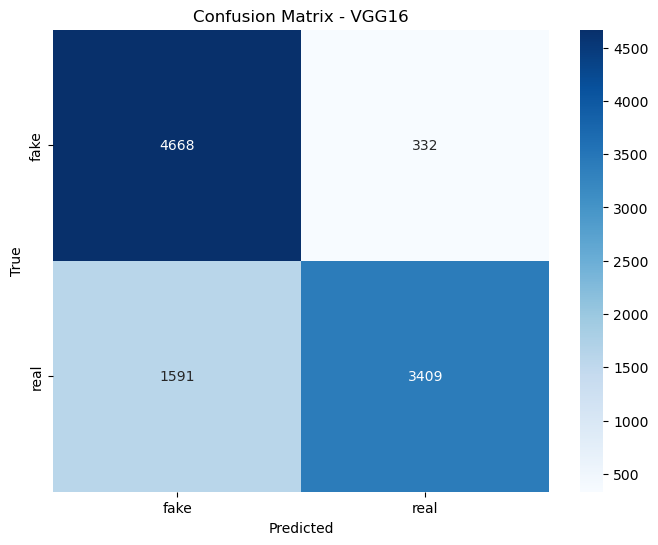

Results for ResNet-50:


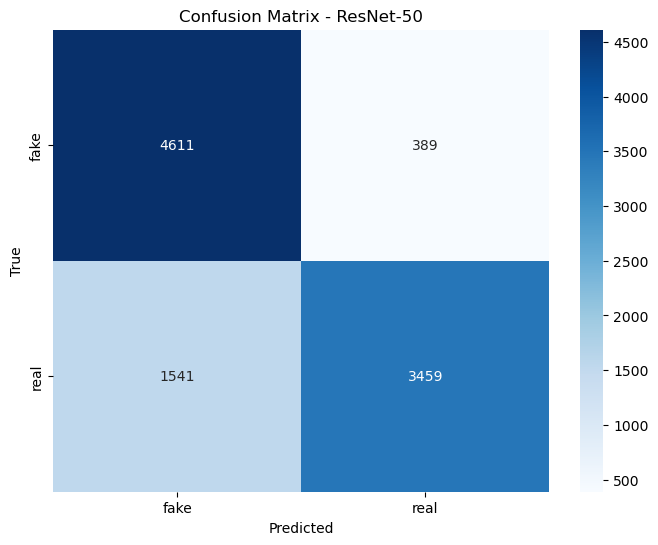

Results for DenseNet121:


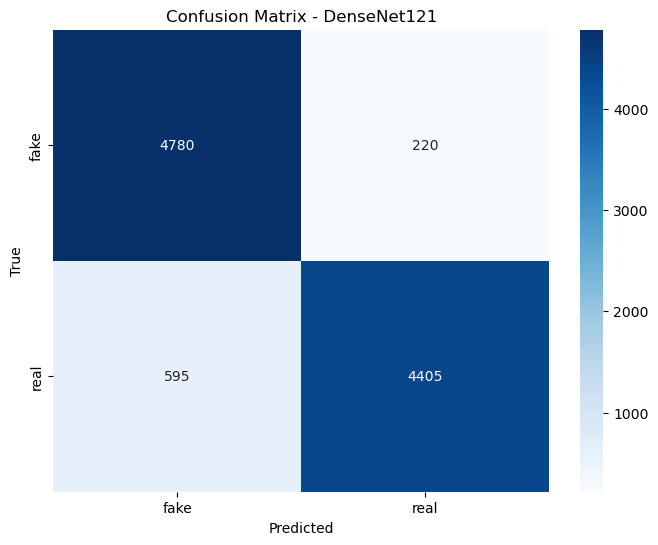

Results for MobileNet:


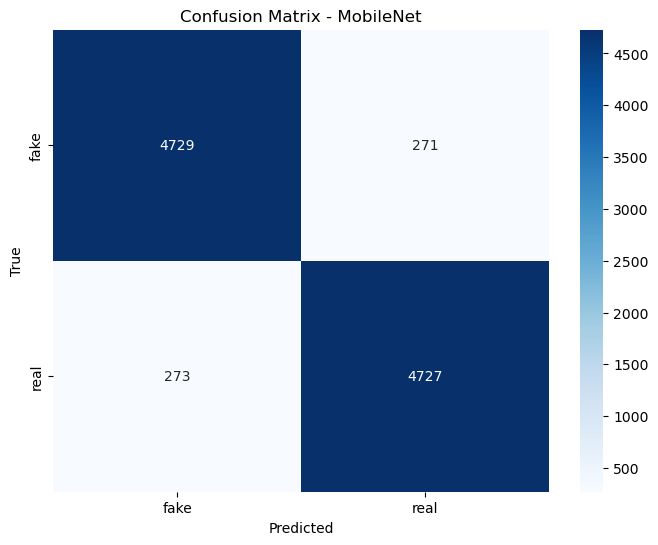

In [34]:
class_names = dataset.classes  

for model_name, metrics in results.items():
    print(f"Results for {model_name}:")
    sum_of_cms = 0
    for fold_idx, fold_metrics in enumerate(metrics):
        sum_of_cms+= fold_metrics['confusion_matrix']
        
    plot_heatmap(sum_of_cms, class_names, model_name)

# bar charts

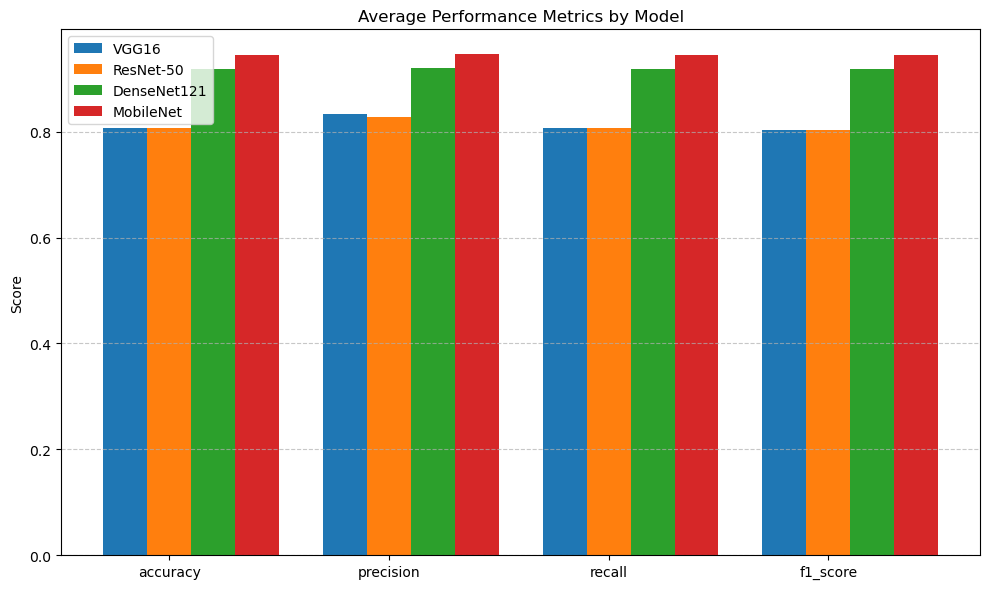

In [35]:
models = list(results.keys())
metrics = ["accuracy", "precision", "recall", "f1_score"]
avg_metrics = {model: [
    np.mean([fold[metric] for fold in results[model]]) for metric in metrics
] for model in models}
fold_metrics = {model: [
    [fold[metric] for metric in metrics] for fold in results[model]
] for model in models}
conf_matrices = {model: [
    np.array(fold["confusion_matrix"]) for fold in results[model]
] for model in models}

plt.figure(figsize=(10, 6))
x = np.arange(len(metrics))
width = 0.2

for i, model in enumerate(models):
    plt.bar(x + i * width, avg_metrics[model], width, label=model)

plt.xticks(x + width, metrics)
plt.ylabel('Score')
plt.title('Average Performance Metrics by Model')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Adding convolution layer to each model

In [40]:
def initialize_model(model_name, num_classes):
    if model_name == "VGG16":
        model = vgg16(weights=VGG16_Weights.DEFAULT)  # Load the most up-to-date weights for VGG16
        for param in model.parameters():
            param.requires_grad = False
        num_ftrs = model.classifier[6].in_features
        model.classifier[6] = nn.Linear(num_ftrs, num_classes)
        model.features.add_module("extra_conv", nn.Conv2d(512, 512, kernel_size=3, padding=1))  
    elif model_name == "ResNet-50":
        model = resnet50(weights=ResNet50_Weights.DEFAULT)  # Load the most up-to-date weights for ResNet-50
        for param in model.parameters():
            param.requires_grad = False
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)
        model.layer4.add_module("extra_conv", nn.Conv2d(2048, 2048, kernel_size=3, padding=1))  
    elif model_name == "DenseNet121":
        model = densenet121(weights=DenseNet121_Weights.DEFAULT)  # Load the most up-to-date weights for DenseNet121
        for param in model.parameters():
            param.requires_grad = False
        num_ftrs = model.classifier.in_features
        model.classifier = nn.Linear(num_ftrs, num_classes)
        model.features.add_module("extra_conv", nn.Conv2d(1024, 1024, kernel_size=3, padding=1))  # Add extra conv layer
    elif model_name == "MobileNet":
        model = mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)  # Load the most up-to-date weights for MobileNet
        for param in model.parameters():
            param.requires_grad = False
        num_ftrs = model.last_channel
        model.classifier[1] = nn.Linear(num_ftrs, num_classes)
        model.features.add_module("extra_conv", nn.Conv2d(1280, 1280, kernel_size=3, padding=1))  
    else:
        print(f"Error: Model '{model_name}' not supported.")
        return None

    for param in model.parameters():
        param.requires_grad = True

    return model

In [41]:
results = {model_name: [] for model_name in our_models}
train_val_hist = []

for fold, (train_idx, test_idx) in enumerate(kf.split(dataset)):
    print(f"Fold {fold+1}/{n_splits}")

    train_set = Subset(dataset, train_idx)
    test_set = Subset(dataset, test_idx)
    val_split = int(len(train_set) * 0.8)
    val_set = Subset(train_set, range(val_split, len(train_set)))
    train_set = Subset(train_set, range(0, val_split))

    train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_set, batch_size=32, shuffle=False)
    
    for model_name in our_models:
        num_classes = len(dataset.classes)
        
        # Initializing the model every time ensures that no previous model parameters are retained
        model = initialize_model(model_name, num_classes)

        # getting best lr for each model
        l_r = get_learning_rate(model_name)

        criterion = torch.nn.CrossEntropyLoss()
        optimizer = Adam(model.parameters(), lr=l_r) 

        model , train_val_history = train_validate_model(model, criterion, optimizer, train_loader, val_loader, fold, model_name, num_epochs=3)
        train_val_hist.append(train_val_history)
        
        # Test the model
        model.eval()
        y_true, y_pred = [], []
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.cuda(), labels.cuda() if torch.cuda.is_available() else (images, labels)
                outputs = model(images)
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(outputs.argmax(1).cpu().numpy())

        cm, acc, prec, rec, f1 = performance_matrix(y_true, y_pred)

        results[model_name].append({
            "confusion_matrix": cm,
            "accuracy": acc,
            "precision": prec,
            "recall": rec,
            "f1_score": f1
        })

Fold 1/3
Epoch 1/3


Training: 100%|██████████████████████████████████████████████████████████████████████| 167/167 [13:14<00:00,  4.76s/it]


[VGG16] Fold 1, Epoch 1: Train Loss: 0.43 Acc: 0.79
[VGG16] Fold 1, Epoch 1: Validation Loss: 0.19 Acc: 0.92

Epoch 2/3


Training: 100%|██████████████████████████████████████████████████████████████████████| 167/167 [13:12<00:00,  4.74s/it]


[VGG16] Fold 1, Epoch 2: Train Loss: 0.16 Acc: 0.94
[VGG16] Fold 1, Epoch 2: Validation Loss: 0.78 Acc: 0.74

Epoch 3/3


Training: 100%|██████████████████████████████████████████████████████████████████████| 167/167 [13:12<00:00,  4.74s/it]


[VGG16] Fold 1, Epoch 3: Train Loss: 0.12 Acc: 0.96
[VGG16] Fold 1, Epoch 3: Validation Loss: 0.05 Acc: 0.99

Best model for VGG16 (Fold 1) saved at: bestmodelsV4\fold1\VGG16_2024-12-26_22-35-04.pth
Epoch 1/3


Training: 100%|██████████████████████████████████████████████████████████████████████| 167/167 [09:55<00:00,  3.57s/it]


[ResNet-50] Fold 1, Epoch 1: Train Loss: 0.54 Acc: 0.76
[ResNet-50] Fold 1, Epoch 1: Validation Loss: 1.41 Acc: 0.60

Epoch 2/3


Training: 100%|██████████████████████████████████████████████████████████████████████| 167/167 [10:05<00:00,  3.63s/it]


[ResNet-50] Fold 1, Epoch 2: Train Loss: 0.28 Acc: 0.89
[ResNet-50] Fold 1, Epoch 2: Validation Loss: 0.21 Acc: 0.93

Epoch 3/3


Training: 100%|██████████████████████████████████████████████████████████████████████| 167/167 [09:57<00:00,  3.58s/it]


[ResNet-50] Fold 1, Epoch 3: Train Loss: 0.19 Acc: 0.93
[ResNet-50] Fold 1, Epoch 3: Validation Loss: 0.25 Acc: 0.92

Best model for ResNet-50 (Fold 1) saved at: bestmodelsV4\fold1\ResNet-50_2024-12-26_23-12-38.pth
Epoch 1/3


Training: 100%|██████████████████████████████████████████████████████████████████████| 167/167 [11:13<00:00,  4.03s/it]


[DenseNet121] Fold 1, Epoch 1: Train Loss: 0.38 Acc: 0.83
[DenseNet121] Fold 1, Epoch 1: Validation Loss: 0.96 Acc: 0.62

Epoch 2/3


Training: 100%|██████████████████████████████████████████████████████████████████████| 167/167 [11:33<00:00,  4.15s/it]


[DenseNet121] Fold 1, Epoch 2: Train Loss: 0.14 Acc: 0.95
[DenseNet121] Fold 1, Epoch 2: Validation Loss: 0.34 Acc: 0.86

Epoch 3/3


Training: 100%|██████████████████████████████████████████████████████████████████████| 167/167 [11:42<00:00,  4.21s/it]


[DenseNet121] Fold 1, Epoch 3: Train Loss: 0.08 Acc: 0.97
[DenseNet121] Fold 1, Epoch 3: Validation Loss: 1.00 Acc: 0.68

Best model for DenseNet121 (Fold 1) saved at: bestmodelsV4\fold1\DenseNet121_2024-12-26_23-50-17.pth
Epoch 1/3


Training: 100%|██████████████████████████████████████████████████████████████████████| 167/167 [00:52<00:00,  3.20it/s]


[MobileNet] Fold 1, Epoch 1: Train Loss: 0.75 Acc: 0.77
[MobileNet] Fold 1, Epoch 1: Validation Loss: 0.10 Acc: 0.98

Epoch 2/3


Training: 100%|██████████████████████████████████████████████████████████████████████| 167/167 [00:51<00:00,  3.23it/s]


[MobileNet] Fold 1, Epoch 2: Train Loss: 0.21 Acc: 0.92
[MobileNet] Fold 1, Epoch 2: Validation Loss: 0.82 Acc: 0.65

Epoch 3/3


Training: 100%|██████████████████████████████████████████████████████████████████████| 167/167 [00:51<00:00,  3.26it/s]


[MobileNet] Fold 1, Epoch 3: Train Loss: 0.11 Acc: 0.96
[MobileNet] Fold 1, Epoch 3: Validation Loss: 0.11 Acc: 0.96

Best model for MobileNet (Fold 1) saved at: bestmodelsV4\fold1\MobileNet_2024-12-26_23-53-40.pth
Fold 2/3
Epoch 1/3


Training: 100%|██████████████████████████████████████████████████████████████████████| 167/167 [13:21<00:00,  4.80s/it]


[VGG16] Fold 2, Epoch 1: Train Loss: 0.46 Acc: 0.78
[VGG16] Fold 2, Epoch 1: Validation Loss: 0.20 Acc: 0.93

Epoch 2/3


Training: 100%|██████████████████████████████████████████████████████████████████████| 167/167 [13:21<00:00,  4.80s/it]


[VGG16] Fold 2, Epoch 2: Train Loss: 0.16 Acc: 0.94
[VGG16] Fold 2, Epoch 2: Validation Loss: 0.19 Acc: 0.91

Epoch 3/3


Training: 100%|██████████████████████████████████████████████████████████████████████| 167/167 [13:14<00:00,  4.76s/it]


[VGG16] Fold 2, Epoch 3: Train Loss: 0.09 Acc: 0.96
[VGG16] Fold 2, Epoch 3: Validation Loss: 0.07 Acc: 0.98

Best model for VGG16 (Fold 2) saved at: bestmodelsV4\fold2\VGG16_2024-12-27_00-41-40.pth
Epoch 1/3


Training: 100%|██████████████████████████████████████████████████████████████████████| 167/167 [12:30<00:00,  4.49s/it]


[ResNet-50] Fold 2, Epoch 1: Train Loss: 0.52 Acc: 0.77
[ResNet-50] Fold 2, Epoch 1: Validation Loss: 0.20 Acc: 0.94

Epoch 2/3


Training: 100%|██████████████████████████████████████████████████████████████████████| 167/167 [12:38<00:00,  4.54s/it]


[ResNet-50] Fold 2, Epoch 2: Train Loss: 0.25 Acc: 0.90
[ResNet-50] Fold 2, Epoch 2: Validation Loss: 0.45 Acc: 0.81

Epoch 3/3


Training: 100%|██████████████████████████████████████████████████████████████████████| 167/167 [12:45<00:00,  4.58s/it]


[ResNet-50] Fold 2, Epoch 3: Train Loss: 0.17 Acc: 0.94
[ResNet-50] Fold 2, Epoch 3: Validation Loss: 0.23 Acc: 0.93

Best model for ResNet-50 (Fold 2) saved at: bestmodelsV4\fold2\ResNet-50_2024-12-27_01-26-42.pth
Epoch 1/3


Training: 100%|██████████████████████████████████████████████████████████████████████| 167/167 [11:36<00:00,  4.17s/it]


[DenseNet121] Fold 2, Epoch 1: Train Loss: 0.33 Acc: 0.86
[DenseNet121] Fold 2, Epoch 1: Validation Loss: 0.26 Acc: 0.90

Epoch 2/3


Training: 100%|██████████████████████████████████████████████████████████████████████| 167/167 [11:35<00:00,  4.17s/it]


[DenseNet121] Fold 2, Epoch 2: Train Loss: 0.15 Acc: 0.94
[DenseNet121] Fold 2, Epoch 2: Validation Loss: 0.26 Acc: 0.90

Epoch 3/3


Training: 100%|██████████████████████████████████████████████████████████████████████| 167/167 [11:34<00:00,  4.16s/it]


[DenseNet121] Fold 2, Epoch 3: Train Loss: 0.07 Acc: 0.98
[DenseNet121] Fold 2, Epoch 3: Validation Loss: 0.57 Acc: 0.77

Best model for DenseNet121 (Fold 2) saved at: bestmodelsV4\fold2\DenseNet121_2024-12-27_02-02-25.pth
Epoch 1/3


Training: 100%|██████████████████████████████████████████████████████████████████████| 167/167 [00:49<00:00,  3.40it/s]


[MobileNet] Fold 2, Epoch 1: Train Loss: 0.58 Acc: 0.81
[MobileNet] Fold 2, Epoch 1: Validation Loss: 0.11 Acc: 0.96

Epoch 2/3


Training: 100%|██████████████████████████████████████████████████████████████████████| 167/167 [00:49<00:00,  3.38it/s]


[MobileNet] Fold 2, Epoch 2: Train Loss: 0.18 Acc: 0.93
[MobileNet] Fold 2, Epoch 2: Validation Loss: 0.16 Acc: 0.92

Epoch 3/3


Training: 100%|██████████████████████████████████████████████████████████████████████| 167/167 [00:49<00:00,  3.35it/s]


[MobileNet] Fold 2, Epoch 3: Train Loss: 0.09 Acc: 0.97
[MobileNet] Fold 2, Epoch 3: Validation Loss: 0.08 Acc: 0.97

Best model for MobileNet (Fold 2) saved at: bestmodelsV4\fold2\MobileNet_2024-12-27_02-05-36.pth
Fold 3/3
Epoch 1/3


Training: 100%|██████████████████████████████████████████████████████████████████████| 167/167 [12:21<00:00,  4.44s/it]


[VGG16] Fold 3, Epoch 1: Train Loss: 0.44 Acc: 0.79
[VGG16] Fold 3, Epoch 1: Validation Loss: 0.29 Acc: 0.87

Epoch 2/3


Training: 100%|██████████████████████████████████████████████████████████████████████| 167/167 [12:18<00:00,  4.42s/it]


[VGG16] Fold 3, Epoch 2: Train Loss: 0.17 Acc: 0.93
[VGG16] Fold 3, Epoch 2: Validation Loss: 0.10 Acc: 0.96

Epoch 3/3


Training: 100%|██████████████████████████████████████████████████████████████████████| 167/167 [12:20<00:00,  4.43s/it]


[VGG16] Fold 3, Epoch 3: Train Loss: 0.08 Acc: 0.97
[VGG16] Fold 3, Epoch 3: Validation Loss: 0.12 Acc: 0.96

Best model for VGG16 (Fold 3) saved at: bestmodelsV4\fold3\VGG16_2024-12-27_02-50-07.pth
Epoch 1/3


Training: 100%|██████████████████████████████████████████████████████████████████████| 167/167 [12:36<00:00,  4.53s/it]


[ResNet-50] Fold 3, Epoch 1: Train Loss: 0.69 Acc: 0.63
[ResNet-50] Fold 3, Epoch 1: Validation Loss: 0.91 Acc: 0.33

Epoch 2/3


Training: 100%|██████████████████████████████████████████████████████████████████████| 167/167 [12:47<00:00,  4.59s/it]


[ResNet-50] Fold 3, Epoch 2: Train Loss: 0.37 Acc: 0.84
[ResNet-50] Fold 3, Epoch 2: Validation Loss: 0.18 Acc: 0.93

Epoch 3/3


Training: 100%|██████████████████████████████████████████████████████████████████████| 167/167 [12:39<00:00,  4.55s/it]


[ResNet-50] Fold 3, Epoch 3: Train Loss: 0.23 Acc: 0.91
[ResNet-50] Fold 3, Epoch 3: Validation Loss: 0.41 Acc: 0.86

Best model for ResNet-50 (Fold 3) saved at: bestmodelsV4\fold3\ResNet-50_2024-12-27_03-34-45.pth
Epoch 1/3


Training: 100%|██████████████████████████████████████████████████████████████████████| 167/167 [11:29<00:00,  4.13s/it]


[DenseNet121] Fold 3, Epoch 1: Train Loss: 0.36 Acc: 0.84
[DenseNet121] Fold 3, Epoch 1: Validation Loss: 0.25 Acc: 0.90

Epoch 2/3


Training: 100%|██████████████████████████████████████████████████████████████████████| 167/167 [11:54<00:00,  4.28s/it]


[DenseNet121] Fold 3, Epoch 2: Train Loss: 0.15 Acc: 0.94
[DenseNet121] Fold 3, Epoch 2: Validation Loss: 0.10 Acc: 0.97

Epoch 3/3


Training: 100%|██████████████████████████████████████████████████████████████████████| 167/167 [12:50<00:00,  4.62s/it]


[DenseNet121] Fold 3, Epoch 3: Train Loss: 0.11 Acc: 0.96
[DenseNet121] Fold 3, Epoch 3: Validation Loss: 0.58 Acc: 0.78

Best model for DenseNet121 (Fold 3) saved at: bestmodelsV4\fold3\DenseNet121_2024-12-27_04-11-58.pth
Epoch 1/3


Training: 100%|██████████████████████████████████████████████████████████████████████| 167/167 [00:50<00:00,  3.30it/s]


[MobileNet] Fold 3, Epoch 1: Train Loss: 0.61 Acc: 0.78
[MobileNet] Fold 3, Epoch 1: Validation Loss: 0.49 Acc: 0.80

Epoch 2/3


Training: 100%|██████████████████████████████████████████████████████████████████████| 167/167 [00:54<00:00,  3.08it/s]


[MobileNet] Fold 3, Epoch 2: Train Loss: 0.19 Acc: 0.93
[MobileNet] Fold 3, Epoch 2: Validation Loss: 0.05 Acc: 0.98

Epoch 3/3


Training: 100%|██████████████████████████████████████████████████████████████████████| 167/167 [00:56<00:00,  2.96it/s]


[MobileNet] Fold 3, Epoch 3: Train Loss: 0.11 Acc: 0.96
[MobileNet] Fold 3, Epoch 3: Validation Loss: 0.06 Acc: 0.98

Best model for MobileNet (Fold 3) saved at: bestmodelsV4\fold3\MobileNet_2024-12-27_04-15-25.pth


In [42]:
for model_name, metrics in results.items():
    print(f"Results for {model_name}:")
    for fold_idx, fold_metrics in enumerate(metrics):
        print(f"  Fold {fold_idx+1}:")
        print(f"    Confusion Matrix:\n{fold_metrics['confusion_matrix']}")
        print(f"    Accuracy: {fold_metrics['accuracy']:.4f}")
        print(f"    Precision: {fold_metrics['precision']:.4f}")
        print(f"    Recall: {fold_metrics['recall']:.4f}")
        print(f"    F1 Score: {fold_metrics['f1_score']:.4f}")

    # Calculate averages
    avg_acc = np.mean([m["accuracy"] for m in metrics])
    avg_prec = np.mean([m["precision"] for m in metrics])
    avg_rec = np.mean([m["recall"] for m in metrics])
    avg_f1 = np.mean([m["f1_score"] for m in metrics])

    print(f"  Averages:")
    print(f"    Accuracy: {avg_acc:.4f}")
    print(f"    Precision: {avg_prec:.4f}")
    print(f"    Recall: {avg_rec:.4f}")
    print(f"    F1 Score: {avg_f1:.4f}")

Results for VGG16:
  Fold 1:
    Confusion Matrix:
[[1452  240]
 [  15 1627]]
    Accuracy: 0.9235
    Precision: 0.9315
    Recall: 0.9235
    F1 Score: 0.9232
  Fold 2:
    Confusion Matrix:
[[1634   64]
 [  34 1601]]
    Accuracy: 0.9706
    Precision: 0.9708
    Recall: 0.9706
    F1 Score: 0.9706
  Fold 3:
    Confusion Matrix:
[[1524   86]
 [  90 1633]]
    Accuracy: 0.9472
    Precision: 0.9472
    Recall: 0.9472
    F1 Score: 0.9472
  Averages:
    Accuracy: 0.9471
    Precision: 0.9498
    Recall: 0.9471
    F1 Score: 0.9470
Results for ResNet-50:
  Fold 1:
    Confusion Matrix:
[[1488  204]
 [ 100 1542]]
    Accuracy: 0.9088
    Precision: 0.9105
    Recall: 0.9088
    F1 Score: 0.9088
  Fold 2:
    Confusion Matrix:
[[1504  194]
 [  98 1537]]
    Accuracy: 0.9124
    Precision: 0.9139
    Recall: 0.9124
    F1 Score: 0.9124
  Fold 3:
    Confusion Matrix:
[[1527   83]
 [ 275 1448]]
    Accuracy: 0.8926
    Precision: 0.8983
    Recall: 0.8926
    F1 Score: 0.8924
  Averages:

Results for VGG16:


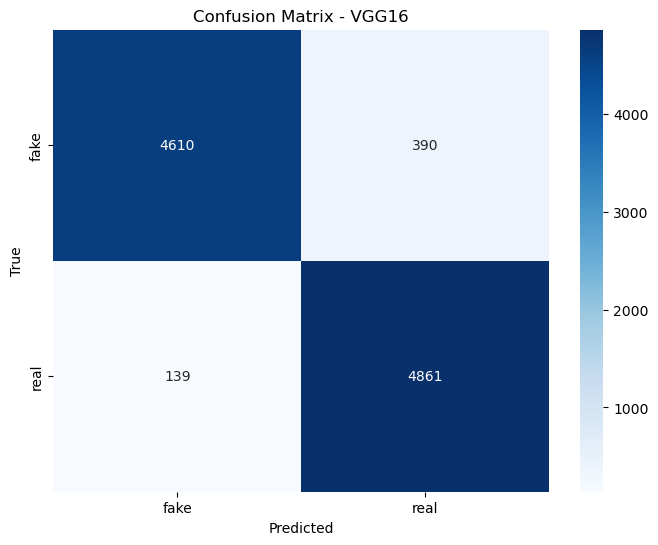

Results for ResNet-50:


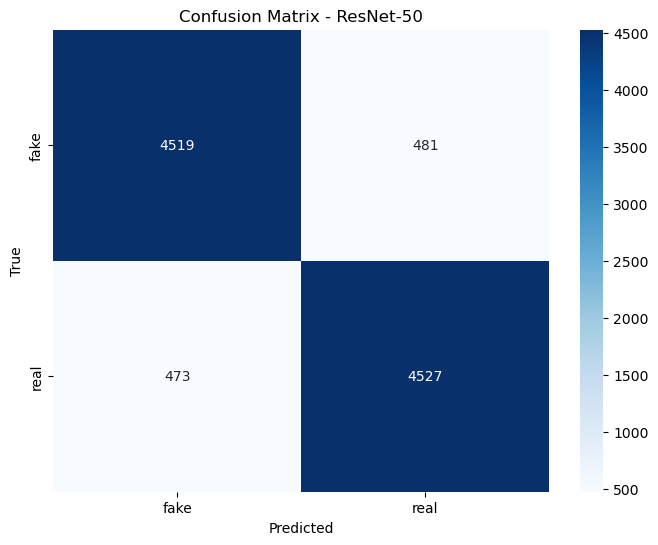

Results for DenseNet121:


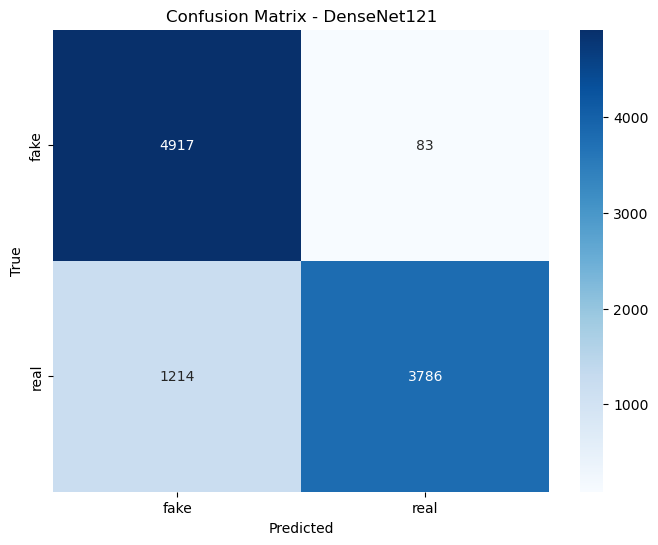

Results for MobileNet:


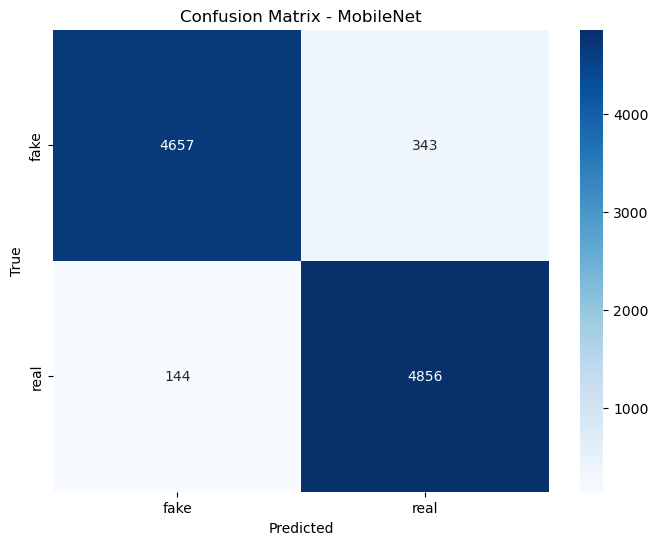

In [43]:
class_names = dataset.classes  

for model_name, metrics in results.items():
    print(f"Results for {model_name}:")
    sum_of_cms = 0
    for fold_idx, fold_metrics in enumerate(metrics):
        sum_of_cms+= fold_metrics['confusion_matrix']
        
    plot_heatmap(sum_of_cms, class_names, model_name)

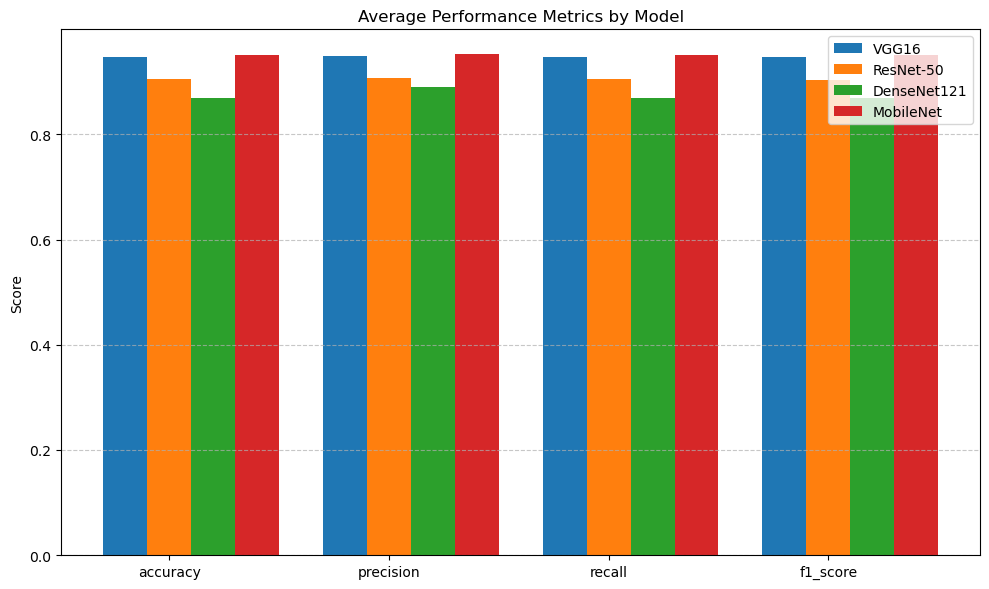

In [44]:
models = list(results.keys())
metrics = ["accuracy", "precision", "recall", "f1_score"]
avg_metrics = {model: [
    np.mean([fold[metric] for fold in results[model]]) for metric in metrics
] for model in models}
fold_metrics = {model: [
    [fold[metric] for metric in metrics] for fold in results[model]
] for model in models}
conf_matrices = {model: [
    np.array(fold["confusion_matrix"]) for fold in results[model]
] for model in models}

plt.figure(figsize=(10, 6))
x = np.arange(len(metrics))
width = 0.2

for i, model in enumerate(models):
    plt.bar(x + i * width, avg_metrics[model], width, label=model)

plt.xticks(x + width, metrics)
plt.ylabel('Score')
plt.title('Average Performance Metrics by Model')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# apply pretrained vision transformer on your dataset

pretrained Vision Transformer is a neural network model designed for image classification tasks, inspired by the Transformer architecture initially developed for natural language processing. The model is pretrained on large datasets (e.g., ImageNet) to learn visual representations, which can then be fine-tuned for specific downstream tasks.

In [45]:
!pip install timm

   ---------------------------------------- 0.0/2.4 MB ? eta -:--:--
   -------- ------------------------------- 0.5/2.4 MB 4.2 MB/s eta 0:00:01
   ---------------------- ----------------- 1.3/2.4 MB 3.4 MB/s eta 0:00:01
   ----------------------------------- ---- 2.1/2.4 MB 3.8 MB/s eta 0:00:01
   ---------------------------------------- 2.4/2.4 MB 3.7 MB/s eta 0:00:00


In [46]:
import timm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

In [47]:
def train_model(model, train_loader, val_loader, lr, num_epoch=2):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=lr)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    for epoch in range(num_epoch):  
        model.train()
        for batch in train_loader:
            images, labels = batch
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for batch in val_loader:
                images, labels = batch
                images, labels = images.to(device), labels.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_loss /= len(val_loader)
        val_acc = 100 * correct / total
        
        print(f"Epoch {epoch+1}, Val Loss: {val_loss / len(val_loader)}, Val Acc: {100 * correct / total}%")
    return model, val_loss, val_acc

## load the dataset loaders

In [48]:
train_set = Subset(dataset, train_idx)
test_set = Subset(dataset, test_idx)
val_split = int(len(train_set) * 0.8)
val_set = Subset(train_set, range(val_split, len(train_set)))
train_set = Subset(train_set, range(0, val_split))

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

## Load a pretrained ViT model 

In [49]:
model = timm.create_model('vit_base_patch16_224', pretrained=True)

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

C:\Users\menam\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\menam\.cache\huggingface\hub\models--timm--vit_base_patch16_224.augreg2_in21k_ft_in1k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


## Modify the Model to match our face detection dataset

In [50]:
class_names = dataset.classes  
model.head = nn.Linear(model.head.in_features, num_classes)

In [53]:
num_epochs = 3
lr = 1e-5
rained_model, val_loss, val_acc = train_model(model, train_loader, val_loader, lr, num_epochs)

Epoch 1, Val Loss: 0.005711533159308997, Val Acc: 92.35382308845577%
Epoch 2, Val Loss: 0.010067563737339242, Val Acc: 89.05547226386807%
Epoch 3, Val Loss: 0.009496799764136811, Val Acc: 90.10494752623688%


In [59]:
print(f"val loss: {val_loss:.2f}")
print(f"val acc: {val_acc:.2f}")

val loss: 0.40
val acc: 90.10


In [62]:
def test_model(model, test_loader):
    results = []
    # Test the model
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.cuda(), labels.cuda() if torch.cuda.is_available() else (images, labels)
            outputs = model(images)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(outputs.argmax(1).cpu().numpy())
    
    cm, acc, prec, rec, f1 = performance_matrix(y_true, y_pred)
    
    results.append({ 
        "confusion_matrix": cm, 
        "accuracy": acc, 
        "precision": prec, 
        "recall": rec, 
        "f1_score": f1
    })
    return results

res = test_model(rained_model, test_loader)

In [63]:
print(res)

[{'confusion_matrix': array([[1554,   56],
       [ 165, 1558]], dtype=int64), 'accuracy': 0.9336933693369337, 'precision': 0.935697740738865, 'recall': 0.9336933693369337, 'f1_score': 0.9336959717333215}]


Results for vit


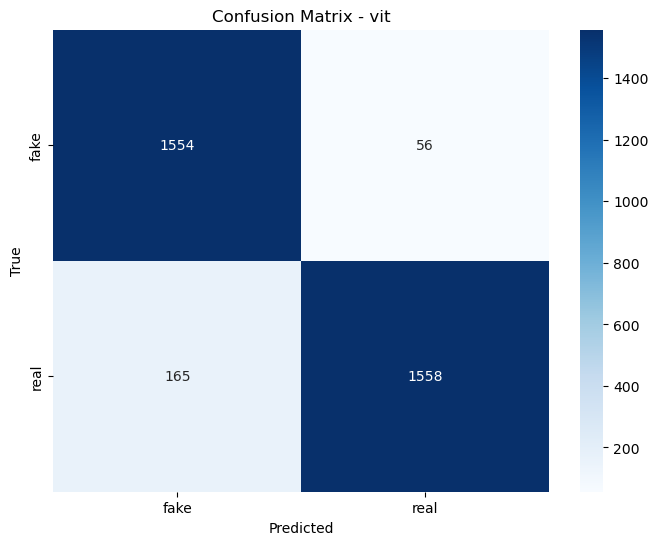

In [66]:
class_names = dataset.classes  

print("Results for vit")
sum_of_cms = res[0]['confusion_matrix']
plot_heatmap(sum_of_cms, class_names, "vit")

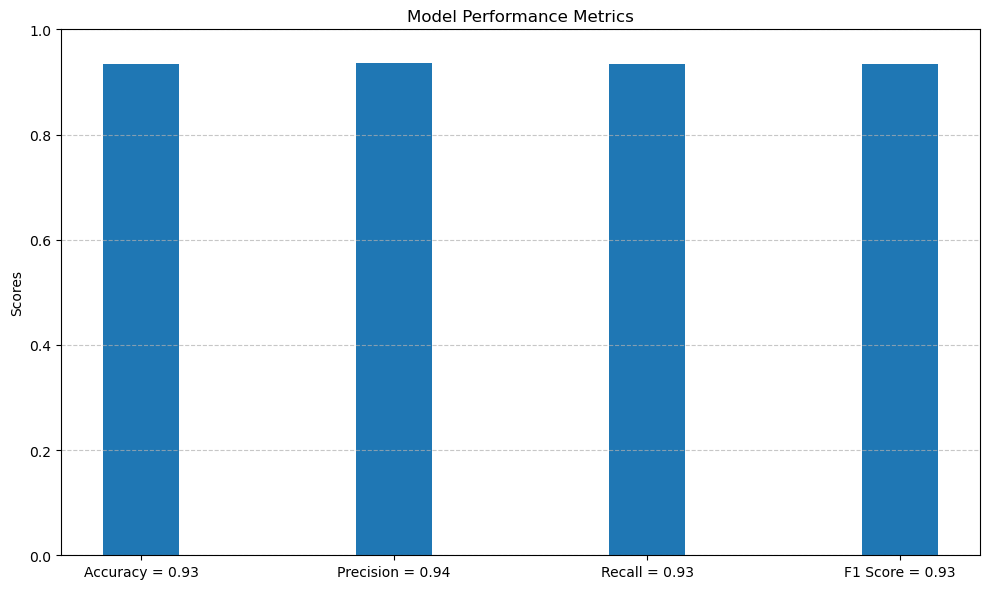

In [75]:
accuracy = res[0]['accuracy']
precision = res[0]['precision']
recall = res[0]['recall']
f1_score = res[0]['f1_score']

x = np.arange(len(metrics))
width = 0.3

# Plotting the metrics
metrics = [f'Accuracy = {accuracy:.2f}', f'Precision = {precision:.2f}', f'Recall = {recall:.2f}', f'F1 Score = {f1_score:.2f}']
values = [accuracy, precision, recall, f1_score]

plt.figure(figsize=(10, 6))
plt.bar(metrics, values, width)
plt.ylim(0, 1)
plt.ylabel('Scores')
plt.title('Model Performance Metrics')
#plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()